# Iterative Vedo model builder

In [1]:
import numpy as np

In [2]:
import vedo

In [3]:
# set the backend for vedo
vedo.settings.default_backend= 'vtk'
#vedo.settings.default_backend= '2d'

In [4]:
from gravmag import aux_vedo

In [5]:
# define the study area
# xmin, xmax, ymin, ymax, zmin, zmax
area = [-5000, 4000, 3500, 11500, -500, 6500]

In [6]:
# define the center coordinates
area_center = (
    0.5*(area[0]+area[1]),
    0.5*(area[2]+area[3]),
    0.5*(area[4]+area[5])
)

In [7]:
# custom axes defining the study area
area_axes = aux_vedo.custom_axes(area=area)

In [8]:
pl = vedo.Plotter()

pl += area_axes

# set a model view
pl.show(
    axes=0, zoom=1, interactive=True
)

# save the chosen view
pl.show(axes=0, zoom=0.95, interactive=False)
#pl.screenshot('iterative_model_builder_1.png')
pl.interactive()

In [9]:
# define a set of planes to create de splines
# for convenience, the planes will be orthogonal to the y-axis
ref_planes_number = 3
ref_planes_ymin = 4600
ref_planes_ymax = 10000
ref_planes_y = np.linspace(
    ref_planes_ymin, ref_planes_ymax, ref_planes_number
)

In [10]:
ref_planes_y

array([ 4600.,  7300., 10000.])

In [11]:
ref_planes_dy = (
    (ref_planes_ymax - ref_planes_ymin)/(ref_planes_number - 1)
)

In [12]:
ref_planes_dy

2700.0

In [13]:
# create the reference plane axes
ref_plane_axes = []
for ref_plane_y in ref_planes_y:
    ref_plane_axes.append(
        aux_vedo.custom_axes(
            area=[area[0], area[1], ref_plane_y, ref_plane_y, area[4], area[5]],
            grids=[False, False, True, False, False, False]
        )
    )

In [14]:
# include the reference planes in the plotter
pl += ref_plane_axes

# save the chosen view
pl.show(axes=0, zoom=0.95, interactive=False)
#pl.screenshot('iterative_model_builder_2.png')
pl.interactive()

In [15]:
# Create a reference circle at each reference plane
ref_points = []
ref_radius = 0.4*np.min([area[1] - area[0], area[5] - area[4]])
pts = vedo.Circle(
    pos = (0, 0, 0),
    r = ref_radius,
    res=8,
    c='red4'
).ps(4)
pts.vertices[:,[2,0,1]] = pts.vertices[:,[0,1,2]]
pts.vertices[:,0] += area_center[0]
pts.vertices[:,2] += area_center[2]
for ref_plane_y in ref_planes_y:
    pts = pts.copy()
    pts.vertices[:,1] = ref_plane_y
    ref_points.append(pts)

In [16]:
# include the reference points in the plotter
for points in ref_points:
    pl += points.point_size(7).alpha(0.7)

# save the chosen view
pl.show(axes=0, zoom=0.95, interactive=False)
#pl.screenshot('iterative_model_builder_3.png')
pl.interactive()

In [17]:
splines = []
for k, (ref_pts, ref_plane_y) in enumerate(zip(ref_points, ref_planes_y)):
    # Add the spline tool using the same points and interact with it
    sptool = pl.add_spline_tool(ref_pts, closed=True)

    # Stay in the loop until the user presses q
    # save the chosen view
    pl.show(axes=0, zoom=0.95, interactive=False)
    #pl.screenshot('iterative_model_builder_4_{}a.png'.format(k+1))
    pl.interactive()
    
    # Extract the resulting spline
    sp = sptool.spline().lw(4).c('black')
    
    # Switch off the tool
    sptool.off()

    # Create a second spline that pass exactly at 
    # the points on the reference plane
    pts = sptool.nodes().copy()
    pts[:,1] = ref_plane_y
    sp2 = vedo.shapes.CSpline(points=pts, closed=True)
    sp2.lw(4).c('red4')
    splines.append(sp2)

    # Visualize the splines
    #pl += sp
    pl += sp2.alpha(0.7)
    
    # save the chosen view
    pl.show(axes=0, zoom=0.95, interactive=False)
    #pl.screenshot('iterative_model_builder_4_{}b.png'.format(k+1))
    pl.interactive()

#pl.close()

In [18]:
Nx = 30
Nz = 21
xgrid = np.linspace(area[0], area[1], Nx)
zgrid = np.linspace(area[4], area[5], Nz)

In [19]:
quad_meshes = []
for (ref_plane_y, spline) in zip(ref_planes_y, splines):
    grd = vedo.Grid(s=[xgrid, zgrid])
    grd.vertices[:,2] = grd.vertices[:,1]
    grd.vertices[:,1] = ref_plane_y
    quad_meshes.append(
        spline.generate_mesh(grid=grd, quads=True)
    )

In [20]:
for quad_mesh in quad_meshes:
    pl += quad_mesh.alpha(0.7)

# save the chosen view
pl.show(axes=0, zoom=0.95, interactive=False)
#pl.screenshot('iterative_model_builder_5.png')
pl.interactive()

In [21]:
# create a model of prisms from the list of quad meshes on the planes
model = aux_vedo.quad_mesh2prisms(quad_meshes=quad_meshes, dy=ref_planes_dy)

In [22]:
# create a random physical property distribution for the prisms
rng = np.random.default_rng(12345)
props = rng.uniform(low=2, high=3, size=model['x1'].size)

In [23]:
# create a model of prisms for vedo
model_vedo = aux_vedo.gravmag2vedo_prisms(
    gravmag_prisms=model,
    scalar_props=props,
    cmap='jet',
    vmin=2,
    vmax=3,
)


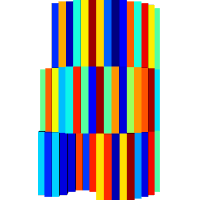

In [24]:
# add a colorbar to the prisms
model_vedo.add_scalarbar(
    title='props (SI)', 
    pos=(0.8,0.05),
    title_yoffset=15,
    font_size=14,
    #nlabels=5,
    #horizontal=True,
    label_format=':6.2f'
)

In [25]:
pl -= ref_plane_axes

pl -= ref_points

pl -= quad_meshes

pl += model_vedo.alpha(0.9)

# # set a model view
# pl.show(
#     axes=0, zoom=1, interactive=True
# )

# save the chosen view
#print('view a')
pl.show(axes=0, zoom=0.95, interactive=False)
#pl.screenshot('iterative_model_builder_6a.png')
pl.interactive()

pl -= splines

## save the chosen view with the splines on the reference planes
#print('view b')
#pl.show(axes=0, zoom=0.95, interactive=False)
#pl.screenshot('iterative_model_builder_6b.png')
#pl.interactive()

## choose another view
#print('set the new view c')
#pl.show(axes=0, zoom=0.95, interactive=False)
#pl.screenshot('iterative_model_builder_6c.png')
#pl.interactive()

## choose another view
#print('set the new view d')
#pl.show(axes=0, zoom=0.95, interactive=False)
#pl.screenshot('iterative_model_builder_6d.png')

In [26]:
pl.interactive()
pl.close()